In [1]:
%matplotlib inline 
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers, Sequential, Model
from tensorflow.keras.layers import Dense, Conv3D, Conv1D, Conv3DTranspose, Dropout, MaxPool3D, Flatten, Reshape, Input, Permute, GlobalAvgPool3D
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np
from random import sample, seed
from tqdm import tqdm
import matplotlib.pyplot as plt

physical_devices = tf.config.experimental.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
# Invalid device or cannot modify virtual devices once initialized.
    pass

from utils.losses import focalSoftMSE

In [126]:

class AAE():
    #Adversarial Autoencoder
    def __init__(self, img_shape=(48, 96, 96, 1), encoded_dim=32, optimizer_generator = Adam(0.00005, beta_1=.5), 
                optimizer_discriminator = Adam(0.00001, beta_1=.5), optimizer_autoencoder = Adam(0.0002, beta_1=.9)):
        self.encoded_dim = encoded_dim
        self.optimizer_generator = optimizer_generator
        self.optimizer_discriminator = optimizer_discriminator
        self.optimizer_autoencoder = optimizer_autoencoder
        self.img_shape = img_shape
        self.initializer = RandomNormal(mean=0., stddev=1.)
        self.encoder, self.decoder, self.autoencoder, self.discriminator, \
                self.discriminator2, self.generator, self.generator2 = self._modelCompile(
                self.img_shape, self.encoded_dim, \
                self.optimizer_autoencoder,\
                self.optimizer_discriminator,\
                self.optimizer_generator
                )

    def _buildEncoder(self, img_shape, encoded_dim):

        encoder = Sequential()
        encoder.add(Conv3D(input_shape = img_shape, filters = 16, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #encoder.add(Dropout(0.2))
        encoder.add(Conv3D(filters = 16, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        encoder.add(layers.BatchNormalization())
        #encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        
        encoder.add(Conv3D(filters = 32, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        encoder.add(layers.BatchNormalization())
        #encoder.add(Dropout(0.2))
        encoder.add(Conv3D(filters = 32, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        encoder.add(layers.BatchNormalization())
        #encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        
        encoder.add(Conv3D(filters = 64, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        encoder.add(layers.BatchNormalization())
        #encoder.add(Dropout(0.2))
        encoder.add(Conv3D(filters = 64, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        encoder.add(layers.BatchNormalization())
        #encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))

        encoder.add(Conv3D(filters = 128, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        encoder.add(layers.BatchNormalization())
#         encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
#         encoder.add(GlobalAvgPool3D())
#         encoder.add(Conv3D(filters = 128, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
#         encoder.add(layers.BatchNormalization())
#         encoder.add(Conv3D(filters = 8, kernel_size=1, strides=(1,)*3, padding="SAME", activation='relu'))
#         encoder.add(layers.BatchNormalization())
#         encoder.add(Flatten())
#         encoder.add(Dense(512, activation="relu"))
#         encoder.add(Dropout(0.3))
#         encoder.add(Dense(512, activation="relu"))
#         encoder.add(Dropout(0.3))
#         encoder.add(Dense(encoded_dim))
        
        return encoder

    def _buildDecoder(self, encoded_dim):

        decoder = Sequential()
#         decoder.add(Dense(512, activation='relu', input_dim=encoded_dim))
#         #decoder.add(Dropout(0.3))
#         decoder.add(Dense(512, activation='relu'))
#         #decoder.add(Dropout(0.3))
#         decoder.add(Dense(6*12*12, activation='relu'))
#         #decoder.add(Dropout(0.3))
#         #decoder.add(Reshape([12*24*24,1]))
#         #decoder.add(Conv1D(filters = 64, kernel_size=1, padding='SAME', activation='relu'))
#         #decoder.add(Permute((2,1)))
#         decoder.add(Reshape([6,12,12,1]))
        decoder.add(Conv3DTranspose(filters=128, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        decoder.add(layers.BatchNormalization())
        decoder.add(Conv3DTranspose(filters=64, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        decoder.add(layers.BatchNormalization())
        decoder.add(Conv3DTranspose(filters=64, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        decoder.add(layers.BatchNormalization())
        decoder.add(Conv3DTranspose(filters=32, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        decoder.add(layers.BatchNormalization())
        decoder.add(Conv3DTranspose(filters=32, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        decoder.add(layers.BatchNormalization())
        decoder.add(Conv3DTranspose(filters=16, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        decoder.add(layers.BatchNormalization())
        decoder.add(Conv3DTranspose(filters=16, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        decoder.add(layers.BatchNormalization())
        decoder.add(Conv3DTranspose(filters=1, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        
        return decoder

    def _buildDiscriminator(self, encoded_dim):

        discriminator = Sequential()
        discriminator.add(Dense(512, input_dim=encoded_dim, activation="relu"))
        discriminator.add(Dense(512, activation="relu"))
        discriminator.add(Dense(64, activation="relu"))
        discriminator.add(Dense(1, activation="sigmoid"))

        return discriminator
    
    def _buildDiscriminator2(self, img_shape):
        
        discriminator = Sequential()
        discriminator.add(Conv3D(input_shape = img_shape, filters = 16, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #discriminator.add(Dropout(0.2))
        #discriminator.add(Conv3D(filters = 16, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        discriminator.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        
        #discriminator.add(Conv3D(filters = 32, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #discriminator.add(Dropout(0.2))
        discriminator.add(Conv3D(filters = 32, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        discriminator.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        
        #discriminator.add(Conv3D(filters = 64, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #discriminator.add(Dropout(0.2))
        discriminator.add(Conv3D(filters = 64, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        discriminator.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))

        discriminator.add(Conv3D(filters = 128, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #discriminator.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        discriminator.add(GlobalAvgPool3D())
        #discriminator.add(Conv3D(filters = 1, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        discriminator.add(Flatten())
        discriminator.add(Dense(128, activation="relu"))
        discriminator.add(Dense(1, activation="sigmoid"))
        
        return discriminator

    def _modelCompile(self, img_shape, encoded_dim, optimizer_autoencoder, optimizer_discriminator, optimizer_generator):

        encoder=self._buildEncoder(img_shape, encoded_dim)
        decoder=self._buildDecoder(encoded_dim)
        
        autoencoder_input = Input(shape = img_shape) # this is the input for autoencoder and main generator
        decoder_input=Input(shape=encoded_dim)
        
        autoencoder=Model(autoencoder_input, decoder(encoder(autoencoder_input)))
        autoencoder.compile(optimizer=optimizer_autoencoder, loss="mse")
        
        discriminator = None
        generator = None
#         discriminator=self._buildDiscriminator(encoded_dim)
#         discriminator.trainable = False
#         generator = Model(autoencoder_input, discriminator(encoder(autoencoder_input)))
#         generator.compile(optimizer=optimizer_generator, loss="mse")
#         discriminator.trainable = True
#         discriminator.compile(optimizer=optimizer_discriminator, loss="mse")
    
        discriminator2 = self._buildDiscriminator2(img_shape)
        discriminator2.trainable = False
        generator2=Model(autoencoder_input, discriminator2(autoencoder(autoencoder_input)))
        generator2.compile(optimizer=optimizer_generator, loss="mse")
        discriminator2.trainable = True
        discriminator2.compile(optimizer=optimizer_discriminator, loss="mse")
        
        return encoder, decoder, autoencoder, discriminator, discriminator2, generator, generator2

    def train(self, train_set, batch_size, n_epochs, n_sample):

        autoencoder_losses = []
        discriminator_losses = []
        discriminator2_losses = []
        generator_losses = []
        generator2_losses = []

        for epoch in np.arange(1, n_epochs):
            x_idx_list = sample(range(n_sample), batch_size)
            x = train_set[x_idx_list]

            autoencoder_history = self.autoencoder.train_on_batch(x,x)
            fake_latent = self.encoder.predict(x)
            fake_image = self.decoder.predict(fake_latent)
            
#             discriminator_input = np.concatenate((fake_latent, np.random.randn(batch_size, self.encoded_dim)))
#             discriminator_labels = np.concatenate((np.zeros((batch_size, 1)), np.ones((batch_size, 1))))
            
            discriminator2_input = np.concatenate((fake_image, x))
            discriminator2_labels = np.concatenate((np.zeros((batch_size, 1)), np.ones((batch_size, 1))))
            
            discriminator_history=0
            generator_history=0
            
            #discriminator_history = self.discriminator.train_on_batch(discriminator_input, discriminator_labels)
            #generator_history = self.generator.train_on_batch(x, np.ones((batch_size, 1)))
            
            discriminator2_history = self.discriminator2.train_on_batch(discriminator2_input, discriminator2_labels)
            generator2_history = self.generator2.train_on_batch(x, np.ones((batch_size, 1)))
            
            autoencoder_losses.append(autoencoder_history)
            discriminator_losses.append(discriminator_history)
            discriminator2_losses.append(discriminator2_history)
            generator_losses.append(generator_history)
            generator2_losses.append(generator2_history)
            
            if epoch == 1:
                loss_min = autoencoder_history
                loss_min_epoch = 1
            
            if epoch > 5 and autoencoder_history < loss_min:
                loss_min = autoencoder_history
                loss_min_epoch = epoch
                self.autoencoder.save("../GAN_log/autoencoder_epoch_{}.h5".format(epoch))
                #self.discriminator.save("../GAN_log/discriminator_epoch_{}.h5".format(epoch))
                
            
            print("Epoch--{}".format(epoch))
            print("AE_loss: {:.4f}  AE_loss_min: {:.4f}  D1_loss:{:.3f}   D2_loss:{:.3f}   G1_loss:{:.3f}   G2_loss:{:.3f}".format(
                autoencoder_history, loss_min, discriminator_history, discriminator2_history, generator_history, generator2_history
                )
            )

        self.history = {
                        'AE_loss':autoencoder_losses, 
                        'D1_loss':discriminator_losses, 
                        'D2_loss':discriminator2_losses, 
                        'G1_loss':generator_losses,
                        'G2_loss':generator2_losses
                       }
        print("Min_loss at epoch: {}".format(loss_min_epoch))
        print("Best model saved at: ../GAN_log/autoencoder_epoch_{}.h5".format(loss_min_epoch))
        
        return self.history

    def load_model(self):

        return

    def encodeImage(self):

        return 

    def plot_losses(self):

        return

In [21]:
import os
import SimpleITK as sitk 

datapath = r'../Data'
file_reference = r'../Training/File_reference.csv'

img_ls = os.listdir(datapath)
train_set = np.zeros(shape=[len(img_ls), 48, 96, 96, 1])

idx = 0
for file in tqdm(img_ls):
    img = sitk.ReadImage(os.path.join(datapath, file))
    img = sitk.GetArrayFromImage(img)
    img = img[:,2:98,2:98,np.newaxis].astype(np.float32) / 255.
    train_set[idx] = img
    idx += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1198/1198 [00:13<00:00, 86.16it/s]


In [127]:
model = AAE(encoded_dim=256)

batch_size=16
n_epochs=6000
seed=42
np.random.seed(42)


In [108]:
history = model.train(train_set, batch_size, n_epochs, len(img_ls))

Epoch--1
AE_loss: 0.7532  AE_loss_min: 0.7532  D1_loss:0.000   D2_loss:0.250   G1_loss:0.000   G2_loss:0.244
Epoch--2
AE_loss: 0.6930  AE_loss_min: 0.7532  D1_loss:0.000   D2_loss:0.250   G1_loss:0.000   G2_loss:0.241
Epoch--3
AE_loss: 0.6276  AE_loss_min: 0.7532  D1_loss:0.000   D2_loss:0.250   G1_loss:0.000   G2_loss:0.239
Epoch--4
AE_loss: 0.5599  AE_loss_min: 0.7532  D1_loss:0.000   D2_loss:0.250   G1_loss:0.000   G2_loss:0.237
Epoch--5
AE_loss: 0.4888  AE_loss_min: 0.7532  D1_loss:0.000   D2_loss:0.249   G1_loss:0.000   G2_loss:0.235
Epoch--6
AE_loss: 0.4294  AE_loss_min: 0.4294  D1_loss:0.000   D2_loss:0.249   G1_loss:0.000   G2_loss:0.234
Epoch--7
AE_loss: 0.3742  AE_loss_min: 0.3742  D1_loss:0.000   D2_loss:0.249   G1_loss:0.000   G2_loss:0.233
Epoch--8
AE_loss: 0.3249  AE_loss_min: 0.3249  D1_loss:0.000   D2_loss:0.249   G1_loss:0.000   G2_loss:0.232
Epoch--9
AE_loss: 0.2900  AE_loss_min: 0.2900  D1_loss:0.000   D2_loss:0.249   G1_loss:0.000   G2_loss:0.231
Epoch--10
AE_loss: 

Epoch--76
AE_loss: 0.0557  AE_loss_min: 0.0550  D1_loss:0.000   D2_loss:0.237   G1_loss:0.000   G2_loss:0.170
Epoch--77
AE_loss: 0.0583  AE_loss_min: 0.0550  D1_loss:0.000   D2_loss:0.234   G1_loss:0.000   G2_loss:0.167
Epoch--78
AE_loss: 0.0635  AE_loss_min: 0.0550  D1_loss:0.000   D2_loss:0.235   G1_loss:0.000   G2_loss:0.164
Epoch--79
AE_loss: 0.0624  AE_loss_min: 0.0550  D1_loss:0.000   D2_loss:0.235   G1_loss:0.000   G2_loss:0.163
Epoch--80
AE_loss: 0.0626  AE_loss_min: 0.0550  D1_loss:0.000   D2_loss:0.235   G1_loss:0.000   G2_loss:0.160
Epoch--81
AE_loss: 0.0615  AE_loss_min: 0.0550  D1_loss:0.000   D2_loss:0.235   G1_loss:0.000   G2_loss:0.159
Epoch--82
AE_loss: 0.0600  AE_loss_min: 0.0550  D1_loss:0.000   D2_loss:0.234   G1_loss:0.000   G2_loss:0.159
Epoch--83
AE_loss: 0.0573  AE_loss_min: 0.0550  D1_loss:0.000   D2_loss:0.234   G1_loss:0.000   G2_loss:0.158
Epoch--84
AE_loss: 0.0591  AE_loss_min: 0.0550  D1_loss:0.000   D2_loss:0.231   G1_loss:0.000   G2_loss:0.156
Epoch--85


Epoch--151
AE_loss: 0.0427  AE_loss_min: 0.0397  D1_loss:0.000   D2_loss:0.212   G1_loss:0.000   G2_loss:0.113
Epoch--152
AE_loss: 0.0420  AE_loss_min: 0.0397  D1_loss:0.000   D2_loss:0.213   G1_loss:0.000   G2_loss:0.113
Epoch--153
AE_loss: 0.0416  AE_loss_min: 0.0397  D1_loss:0.000   D2_loss:0.213   G1_loss:0.000   G2_loss:0.113
Epoch--154
AE_loss: 0.0359  AE_loss_min: 0.0359  D1_loss:0.000   D2_loss:0.217   G1_loss:0.000   G2_loss:0.119
Epoch--155
AE_loss: 0.0427  AE_loss_min: 0.0359  D1_loss:0.000   D2_loss:0.212   G1_loss:0.000   G2_loss:0.116
Epoch--156
AE_loss: 0.0412  AE_loss_min: 0.0359  D1_loss:0.000   D2_loss:0.212   G1_loss:0.000   G2_loss:0.115
Epoch--157
AE_loss: 0.0397  AE_loss_min: 0.0359  D1_loss:0.000   D2_loss:0.212   G1_loss:0.000   G2_loss:0.116
Epoch--158
AE_loss: 0.0398  AE_loss_min: 0.0359  D1_loss:0.000   D2_loss:0.215   G1_loss:0.000   G2_loss:0.116
Epoch--159
AE_loss: 0.0412  AE_loss_min: 0.0359  D1_loss:0.000   D2_loss:0.212   G1_loss:0.000   G2_loss:0.116
E

Epoch--225
AE_loss: 0.0365  AE_loss_min: 0.0323  D1_loss:0.000   D2_loss:0.178   G1_loss:0.000   G2_loss:0.110
Epoch--226
AE_loss: 0.0372  AE_loss_min: 0.0323  D1_loss:0.000   D2_loss:0.173   G1_loss:0.000   G2_loss:0.107
Epoch--227
AE_loss: 0.0372  AE_loss_min: 0.0323  D1_loss:0.000   D2_loss:0.172   G1_loss:0.000   G2_loss:0.105
Epoch--228
AE_loss: 0.0364  AE_loss_min: 0.0323  D1_loss:0.000   D2_loss:0.175   G1_loss:0.000   G2_loss:0.107
Epoch--229
AE_loss: 0.0360  AE_loss_min: 0.0323  D1_loss:0.000   D2_loss:0.174   G1_loss:0.000   G2_loss:0.107
Epoch--230
AE_loss: 0.0389  AE_loss_min: 0.0323  D1_loss:0.000   D2_loss:0.168   G1_loss:0.000   G2_loss:0.104
Epoch--231
AE_loss: 0.0374  AE_loss_min: 0.0323  D1_loss:0.000   D2_loss:0.168   G1_loss:0.000   G2_loss:0.102
Epoch--232
AE_loss: 0.0343  AE_loss_min: 0.0323  D1_loss:0.000   D2_loss:0.175   G1_loss:0.000   G2_loss:0.104
Epoch--233
AE_loss: 0.0366  AE_loss_min: 0.0323  D1_loss:0.000   D2_loss:0.172   G1_loss:0.000   G2_loss:0.102
E

Epoch--299
AE_loss: 0.0320  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.176   G1_loss:0.000   G2_loss:0.128
Epoch--300
AE_loss: 0.0368  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.163   G1_loss:0.000   G2_loss:0.127
Epoch--301
AE_loss: 0.0359  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.167   G1_loss:0.000   G2_loss:0.129
Epoch--302
AE_loss: 0.0322  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.174   G1_loss:0.000   G2_loss:0.133
Epoch--303
AE_loss: 0.0341  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.168   G1_loss:0.000   G2_loss:0.141
Epoch--304
AE_loss: 0.0366  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.164   G1_loss:0.000   G2_loss:0.144
Epoch--305
AE_loss: 0.0342  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.178   G1_loss:0.000   G2_loss:0.148
Epoch--306
AE_loss: 0.0357  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.178   G1_loss:0.000   G2_loss:0.150
Epoch--307
AE_loss: 0.0359  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.170   G1_loss:0.000   G2_loss:0.151
E

Epoch--373
AE_loss: 0.0328  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.105   G1_loss:0.000   G2_loss:0.231
Epoch--374
AE_loss: 0.0324  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.108   G1_loss:0.000   G2_loss:0.229
Epoch--375
AE_loss: 0.0341  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.103   G1_loss:0.000   G2_loss:0.222
Epoch--376
AE_loss: 0.0330  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.111   G1_loss:0.000   G2_loss:0.216
Epoch--377
AE_loss: 0.0344  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.105   G1_loss:0.000   G2_loss:0.214
Epoch--378
AE_loss: 0.0320  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.110   G1_loss:0.000   G2_loss:0.216
Epoch--379
AE_loss: 0.0328  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.112   G1_loss:0.000   G2_loss:0.202
Epoch--380
AE_loss: 0.0303  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.113   G1_loss:0.000   G2_loss:0.196
Epoch--381
AE_loss: 0.0372  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.101   G1_loss:0.000   G2_loss:0.192
E

Epoch--447
AE_loss: 0.0308  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.075   G1_loss:0.000   G2_loss:0.288
Epoch--448
AE_loss: 0.0293  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.070   G1_loss:0.000   G2_loss:0.288
Epoch--449
AE_loss: 0.0319  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.061   G1_loss:0.000   G2_loss:0.274
Epoch--450
AE_loss: 0.0302  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.066   G1_loss:0.000   G2_loss:0.272
Epoch--451
AE_loss: 0.0310  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.074   G1_loss:0.000   G2_loss:0.275
Epoch--452
AE_loss: 0.0336  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.060   G1_loss:0.000   G2_loss:0.276
Epoch--453
AE_loss: 0.0296  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.077   G1_loss:0.000   G2_loss:0.273
Epoch--454
AE_loss: 0.0317  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.070   G1_loss:0.000   G2_loss:0.251
Epoch--455
AE_loss: 0.0331  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.059   G1_loss:0.000   G2_loss:0.257
E

Epoch--521
AE_loss: 0.0302  AE_loss_min: 0.0267  D1_loss:0.000   D2_loss:0.040   G1_loss:0.000   G2_loss:0.207
Epoch--522
AE_loss: 0.0302  AE_loss_min: 0.0267  D1_loss:0.000   D2_loss:0.039   G1_loss:0.000   G2_loss:0.199
Epoch--523
AE_loss: 0.0309  AE_loss_min: 0.0267  D1_loss:0.000   D2_loss:0.037   G1_loss:0.000   G2_loss:0.196
Epoch--524
AE_loss: 0.0300  AE_loss_min: 0.0267  D1_loss:0.000   D2_loss:0.037   G1_loss:0.000   G2_loss:0.196
Epoch--525
AE_loss: 0.0281  AE_loss_min: 0.0267  D1_loss:0.000   D2_loss:0.041   G1_loss:0.000   G2_loss:0.210
Epoch--526
AE_loss: 0.0265  AE_loss_min: 0.0265  D1_loss:0.000   D2_loss:0.058   G1_loss:0.000   G2_loss:0.218
Epoch--527
AE_loss: 0.0276  AE_loss_min: 0.0265  D1_loss:0.000   D2_loss:0.059   G1_loss:0.000   G2_loss:0.209
Epoch--528
AE_loss: 0.0279  AE_loss_min: 0.0265  D1_loss:0.000   D2_loss:0.055   G1_loss:0.000   G2_loss:0.196
Epoch--529
AE_loss: 0.0296  AE_loss_min: 0.0265  D1_loss:0.000   D2_loss:0.040   G1_loss:0.000   G2_loss:0.183
E

Epoch--595
AE_loss: 0.0292  AE_loss_min: 0.0255  D1_loss:0.000   D2_loss:0.019   G1_loss:0.000   G2_loss:0.212
Epoch--596
AE_loss: 0.0268  AE_loss_min: 0.0255  D1_loss:0.000   D2_loss:0.023   G1_loss:0.000   G2_loss:0.209
Epoch--597
AE_loss: 0.0272  AE_loss_min: 0.0255  D1_loss:0.000   D2_loss:0.031   G1_loss:0.000   G2_loss:0.236
Epoch--598
AE_loss: 0.0271  AE_loss_min: 0.0255  D1_loss:0.000   D2_loss:0.022   G1_loss:0.000   G2_loss:0.217
Epoch--599
AE_loss: 0.0280  AE_loss_min: 0.0255  D1_loss:0.000   D2_loss:0.033   G1_loss:0.000   G2_loss:0.219
Epoch--600
AE_loss: 0.0298  AE_loss_min: 0.0255  D1_loss:0.000   D2_loss:0.017   G1_loss:0.000   G2_loss:0.220
Epoch--601
AE_loss: 0.0293  AE_loss_min: 0.0255  D1_loss:0.000   D2_loss:0.017   G1_loss:0.000   G2_loss:0.230
Epoch--602
AE_loss: 0.0259  AE_loss_min: 0.0255  D1_loss:0.000   D2_loss:0.034   G1_loss:0.000   G2_loss:0.246
Epoch--603
AE_loss: 0.0285  AE_loss_min: 0.0255  D1_loss:0.000   D2_loss:0.025   G1_loss:0.000   G2_loss:0.220
E

Epoch--669
AE_loss: 0.0212  AE_loss_min: 0.0204  D1_loss:0.000   D2_loss:0.009   G1_loss:0.000   G2_loss:0.061
Epoch--670
AE_loss: 0.0208  AE_loss_min: 0.0204  D1_loss:0.000   D2_loss:0.008   G1_loss:0.000   G2_loss:0.060
Epoch--671
AE_loss: 0.0188  AE_loss_min: 0.0188  D1_loss:0.000   D2_loss:0.010   G1_loss:0.000   G2_loss:0.070
Epoch--672
AE_loss: 0.0204  AE_loss_min: 0.0188  D1_loss:0.000   D2_loss:0.023   G1_loss:0.000   G2_loss:0.063
Epoch--673
AE_loss: 0.0198  AE_loss_min: 0.0188  D1_loss:0.000   D2_loss:0.007   G1_loss:0.000   G2_loss:0.059
Epoch--674
AE_loss: 0.0203  AE_loss_min: 0.0188  D1_loss:0.000   D2_loss:0.008   G1_loss:0.000   G2_loss:0.060
Epoch--675
AE_loss: 0.0199  AE_loss_min: 0.0188  D1_loss:0.000   D2_loss:0.006   G1_loss:0.000   G2_loss:0.051
Epoch--676
AE_loss: 0.0201  AE_loss_min: 0.0188  D1_loss:0.000   D2_loss:0.006   G1_loss:0.000   G2_loss:0.042
Epoch--677
AE_loss: 0.0200  AE_loss_min: 0.0188  D1_loss:0.000   D2_loss:0.006   G1_loss:0.000   G2_loss:0.047
E

Epoch--743
AE_loss: 0.0117  AE_loss_min: 0.0109  D1_loss:0.000   D2_loss:0.021   G1_loss:0.000   G2_loss:0.020
Epoch--744
AE_loss: 0.0112  AE_loss_min: 0.0109  D1_loss:0.000   D2_loss:0.012   G1_loss:0.000   G2_loss:0.016
Epoch--745
AE_loss: 0.0112  AE_loss_min: 0.0109  D1_loss:0.000   D2_loss:0.015   G1_loss:0.000   G2_loss:0.020
Epoch--746
AE_loss: 0.0114  AE_loss_min: 0.0109  D1_loss:0.000   D2_loss:0.007   G1_loss:0.000   G2_loss:0.012
Epoch--747
AE_loss: 0.0106  AE_loss_min: 0.0106  D1_loss:0.000   D2_loss:0.047   G1_loss:0.000   G2_loss:0.063
Epoch--748
AE_loss: 0.0112  AE_loss_min: 0.0106  D1_loss:0.000   D2_loss:0.049   G1_loss:0.000   G2_loss:0.046
Epoch--749
AE_loss: 0.0130  AE_loss_min: 0.0106  D1_loss:0.000   D2_loss:0.020   G1_loss:0.000   G2_loss:0.007
Epoch--750
AE_loss: 0.0117  AE_loss_min: 0.0106  D1_loss:0.000   D2_loss:0.020   G1_loss:0.000   G2_loss:0.013
Epoch--751
AE_loss: 0.0106  AE_loss_min: 0.0106  D1_loss:0.000   D2_loss:0.024   G1_loss:0.000   G2_loss:0.041
E

Epoch--817
AE_loss: 0.0090  AE_loss_min: 0.0083  D1_loss:0.000   D2_loss:0.057   G1_loss:0.000   G2_loss:0.027
Epoch--818
AE_loss: 0.0094  AE_loss_min: 0.0083  D1_loss:0.000   D2_loss:0.068   G1_loss:0.000   G2_loss:0.058
Epoch--819
AE_loss: 0.0090  AE_loss_min: 0.0083  D1_loss:0.000   D2_loss:0.045   G1_loss:0.000   G2_loss:0.020
Epoch--820
AE_loss: 0.0085  AE_loss_min: 0.0083  D1_loss:0.000   D2_loss:0.050   G1_loss:0.000   G2_loss:0.027
Epoch--821
AE_loss: 0.0093  AE_loss_min: 0.0083  D1_loss:0.000   D2_loss:0.013   G1_loss:0.000   G2_loss:0.023
Epoch--822
AE_loss: 0.0090  AE_loss_min: 0.0083  D1_loss:0.000   D2_loss:0.048   G1_loss:0.000   G2_loss:0.042
Epoch--823
AE_loss: 0.0090  AE_loss_min: 0.0083  D1_loss:0.000   D2_loss:0.040   G1_loss:0.000   G2_loss:0.024
Epoch--824
AE_loss: 0.0090  AE_loss_min: 0.0083  D1_loss:0.000   D2_loss:0.038   G1_loss:0.000   G2_loss:0.029
Epoch--825
AE_loss: 0.0086  AE_loss_min: 0.0083  D1_loss:0.000   D2_loss:0.054   G1_loss:0.000   G2_loss:0.055
E

Epoch--891
AE_loss: 0.0078  AE_loss_min: 0.0071  D1_loss:0.000   D2_loss:0.156   G1_loss:0.000   G2_loss:0.070
Epoch--892
AE_loss: 0.0078  AE_loss_min: 0.0071  D1_loss:0.000   D2_loss:0.118   G1_loss:0.000   G2_loss:0.045
Epoch--893
AE_loss: 0.0074  AE_loss_min: 0.0071  D1_loss:0.000   D2_loss:0.081   G1_loss:0.000   G2_loss:0.070
Epoch--894
AE_loss: 0.0075  AE_loss_min: 0.0071  D1_loss:0.000   D2_loss:0.047   G1_loss:0.000   G2_loss:0.055
Epoch--895
AE_loss: 0.0082  AE_loss_min: 0.0071  D1_loss:0.000   D2_loss:0.059   G1_loss:0.000   G2_loss:0.033
Epoch--896
AE_loss: 0.0072  AE_loss_min: 0.0071  D1_loss:0.000   D2_loss:0.098   G1_loss:0.000   G2_loss:0.047
Epoch--897
AE_loss: 0.0080  AE_loss_min: 0.0071  D1_loss:0.000   D2_loss:0.066   G1_loss:0.000   G2_loss:0.061
Epoch--898
AE_loss: 0.0071  AE_loss_min: 0.0071  D1_loss:0.000   D2_loss:0.106   G1_loss:0.000   G2_loss:0.076
Epoch--899
AE_loss: 0.0076  AE_loss_min: 0.0071  D1_loss:0.000   D2_loss:0.127   G1_loss:0.000   G2_loss:0.094
E

Epoch--965
AE_loss: 0.0065  AE_loss_min: 0.0064  D1_loss:0.000   D2_loss:0.101   G1_loss:0.000   G2_loss:0.072
Epoch--966
AE_loss: 0.0065  AE_loss_min: 0.0064  D1_loss:0.000   D2_loss:0.095   G1_loss:0.000   G2_loss:0.082
Epoch--967
AE_loss: 0.0067  AE_loss_min: 0.0064  D1_loss:0.000   D2_loss:0.060   G1_loss:0.000   G2_loss:0.064
Epoch--968
AE_loss: 0.0070  AE_loss_min: 0.0064  D1_loss:0.000   D2_loss:0.107   G1_loss:0.000   G2_loss:0.090
Epoch--969
AE_loss: 0.0075  AE_loss_min: 0.0064  D1_loss:0.000   D2_loss:0.170   G1_loss:0.000   G2_loss:0.111
Epoch--970
AE_loss: 0.0071  AE_loss_min: 0.0064  D1_loss:0.000   D2_loss:0.101   G1_loss:0.000   G2_loss:0.042
Epoch--971
AE_loss: 0.0074  AE_loss_min: 0.0064  D1_loss:0.000   D2_loss:0.076   G1_loss:0.000   G2_loss:0.060
Epoch--972
AE_loss: 0.0067  AE_loss_min: 0.0064  D1_loss:0.000   D2_loss:0.104   G1_loss:0.000   G2_loss:0.083
Epoch--973
AE_loss: 0.0070  AE_loss_min: 0.0064  D1_loss:0.000   D2_loss:0.079   G1_loss:0.000   G2_loss:0.077
E

Epoch--1039
AE_loss: 0.0072  AE_loss_min: 0.0059  D1_loss:0.000   D2_loss:0.085   G1_loss:0.000   G2_loss:0.031
Epoch--1040
AE_loss: 0.0069  AE_loss_min: 0.0059  D1_loss:0.000   D2_loss:0.088   G1_loss:0.000   G2_loss:0.030
Epoch--1041
AE_loss: 0.0067  AE_loss_min: 0.0059  D1_loss:0.000   D2_loss:0.132   G1_loss:0.000   G2_loss:0.061
Epoch--1042
AE_loss: 0.0073  AE_loss_min: 0.0059  D1_loss:0.000   D2_loss:0.090   G1_loss:0.000   G2_loss:0.030
Epoch--1043
AE_loss: 0.0068  AE_loss_min: 0.0059  D1_loss:0.000   D2_loss:0.058   G1_loss:0.000   G2_loss:0.028
Epoch--1044
AE_loss: 0.0058  AE_loss_min: 0.0058  D1_loss:0.000   D2_loss:0.066   G1_loss:0.000   G2_loss:0.016
Epoch--1045
AE_loss: 0.0066  AE_loss_min: 0.0058  D1_loss:0.000   D2_loss:0.097   G1_loss:0.000   G2_loss:0.054
Epoch--1046
AE_loss: 0.0064  AE_loss_min: 0.0058  D1_loss:0.000   D2_loss:0.076   G1_loss:0.000   G2_loss:0.045
Epoch--1047
AE_loss: 0.0064  AE_loss_min: 0.0058  D1_loss:0.000   D2_loss:0.058   G1_loss:0.000   G2_los

Epoch--1113
AE_loss: 0.0059  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.076   G1_loss:0.000   G2_loss:0.063
Epoch--1114
AE_loss: 0.0054  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.064   G1_loss:0.000   G2_loss:0.047
Epoch--1115
AE_loss: 0.0055  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.084   G1_loss:0.000   G2_loss:0.060
Epoch--1116
AE_loss: 0.0065  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.130   G1_loss:0.000   G2_loss:0.049
Epoch--1117
AE_loss: 0.0054  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.053   G1_loss:0.000   G2_loss:0.028
Epoch--1118
AE_loss: 0.0069  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.065   G1_loss:0.000   G2_loss:0.043
Epoch--1119
AE_loss: 0.0067  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.109   G1_loss:0.000   G2_loss:0.032
Epoch--1120
AE_loss: 0.0058  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.112   G1_loss:0.000   G2_loss:0.041
Epoch--1121
AE_loss: 0.0069  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.102   G1_loss:0.000   G2_los

Epoch--1187
AE_loss: 0.0062  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.114   G1_loss:0.000   G2_loss:0.048
Epoch--1188
AE_loss: 0.0054  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.118   G1_loss:0.000   G2_loss:0.051
Epoch--1189
AE_loss: 0.0060  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.106   G1_loss:0.000   G2_loss:0.051
Epoch--1190
AE_loss: 0.0064  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.187   G1_loss:0.000   G2_loss:0.077
Epoch--1191
AE_loss: 0.0065  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.156   G1_loss:0.000   G2_loss:0.062
Epoch--1192
AE_loss: 0.0060  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.139   G1_loss:0.000   G2_loss:0.056
Epoch--1193
AE_loss: 0.0062  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.129   G1_loss:0.000   G2_loss:0.043
Epoch--1194
AE_loss: 0.0064  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.071   G1_loss:0.000   G2_loss:0.037
Epoch--1195
AE_loss: 0.0055  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.142   G1_loss:0.000   G2_los

Epoch--1261
AE_loss: 0.0061  AE_loss_min: 0.0052  D1_loss:0.000   D2_loss:0.075   G1_loss:0.000   G2_loss:0.084
Epoch--1262
AE_loss: 0.0060  AE_loss_min: 0.0052  D1_loss:0.000   D2_loss:0.072   G1_loss:0.000   G2_loss:0.072
Epoch--1263
AE_loss: 0.0059  AE_loss_min: 0.0052  D1_loss:0.000   D2_loss:0.112   G1_loss:0.000   G2_loss:0.130
Epoch--1264
AE_loss: 0.0061  AE_loss_min: 0.0052  D1_loss:0.000   D2_loss:0.061   G1_loss:0.000   G2_loss:0.053
Epoch--1265
AE_loss: 0.0065  AE_loss_min: 0.0052  D1_loss:0.000   D2_loss:0.045   G1_loss:0.000   G2_loss:0.032
Epoch--1266
AE_loss: 0.0055  AE_loss_min: 0.0052  D1_loss:0.000   D2_loss:0.085   G1_loss:0.000   G2_loss:0.073
Epoch--1267
AE_loss: 0.0062  AE_loss_min: 0.0052  D1_loss:0.000   D2_loss:0.118   G1_loss:0.000   G2_loss:0.091
Epoch--1268
AE_loss: 0.0059  AE_loss_min: 0.0052  D1_loss:0.000   D2_loss:0.073   G1_loss:0.000   G2_loss:0.100
Epoch--1269
AE_loss: 0.0064  AE_loss_min: 0.0052  D1_loss:0.000   D2_loss:0.022   G1_loss:0.000   G2_los

Epoch--1335
AE_loss: 0.0063  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.025   G1_loss:0.000   G2_loss:0.024
Epoch--1336
AE_loss: 0.0055  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.029   G1_loss:0.000   G2_loss:0.032
Epoch--1337
AE_loss: 0.0057  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.068   G1_loss:0.000   G2_loss:0.106
Epoch--1338
AE_loss: 0.0057  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.076   G1_loss:0.000   G2_loss:0.097
Epoch--1339
AE_loss: 0.0051  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.053   G1_loss:0.000   G2_loss:0.119
Epoch--1340
AE_loss: 0.0060  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.069   G1_loss:0.000   G2_loss:0.061
Epoch--1341
AE_loss: 0.0059  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.025   G1_loss:0.000   G2_loss:0.029
Epoch--1342
AE_loss: 0.0060  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.028   G1_loss:0.000   G2_loss:0.038
Epoch--1343
AE_loss: 0.0062  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.015   G1_loss:0.000   G2_los

Epoch--1409
AE_loss: 0.0065  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.019   G1_loss:0.000   G2_loss:0.031
Epoch--1410
AE_loss: 0.0061  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.024   G1_loss:0.000   G2_loss:0.029
Epoch--1411
AE_loss: 0.0063  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.072   G1_loss:0.000   G2_loss:0.087
Epoch--1412
AE_loss: 0.0068  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.020   G1_loss:0.000   G2_loss:0.030
Epoch--1413
AE_loss: 0.0063  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.067   G1_loss:0.000   G2_loss:0.103
Epoch--1414
AE_loss: 0.0061  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.100   G1_loss:0.000   G2_loss:0.121
Epoch--1415
AE_loss: 0.0059  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.018   G1_loss:0.000   G2_loss:0.092
Epoch--1416
AE_loss: 0.0062  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.039   G1_loss:0.000   G2_loss:0.030
Epoch--1417
AE_loss: 0.0072  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.056   G1_loss:0.000   G2_los

Epoch--1483
AE_loss: 0.0079  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.009   G1_loss:0.000   G2_loss:0.191
Epoch--1484
AE_loss: 0.0059  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.023   G1_loss:0.000   G2_loss:0.183
Epoch--1485
AE_loss: 0.0074  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.006   G1_loss:0.000   G2_loss:0.190
Epoch--1486
AE_loss: 0.0068  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.033   G1_loss:0.000   G2_loss:0.202
Epoch--1487
AE_loss: 0.0064  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.027   G1_loss:0.000   G2_loss:0.188
Epoch--1488
AE_loss: 0.0071  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.018   G1_loss:0.000   G2_loss:0.207
Epoch--1489
AE_loss: 0.0067  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.032   G1_loss:0.000   G2_loss:0.134
Epoch--1490
AE_loss: 0.0072  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.057   G1_loss:0.000   G2_loss:0.111
Epoch--1491
AE_loss: 0.0068  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.055   G1_loss:0.000   G2_los

Epoch--1557
AE_loss: 0.0070  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.016   G1_loss:0.000   G2_loss:0.497
Epoch--1558
AE_loss: 0.0065  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.030   G1_loss:0.000   G2_loss:0.366
Epoch--1559
AE_loss: 0.0067  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.045   G1_loss:0.000   G2_loss:0.327
Epoch--1560
AE_loss: 0.0059  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.025   G1_loss:0.000   G2_loss:0.332
Epoch--1561
AE_loss: 0.0068  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.023   G1_loss:0.000   G2_loss:0.327
Epoch--1562
AE_loss: 0.0069  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.022   G1_loss:0.000   G2_loss:0.288
Epoch--1563
AE_loss: 0.0067  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.014   G1_loss:0.000   G2_loss:0.253
Epoch--1564
AE_loss: 0.0071  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.056   G1_loss:0.000   G2_loss:0.265
Epoch--1565
AE_loss: 0.0072  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.027   G1_loss:0.000   G2_los

Epoch--1631
AE_loss: 0.0062  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.019   G1_loss:0.000   G2_loss:0.422
Epoch--1632
AE_loss: 0.0061  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.025   G1_loss:0.000   G2_loss:0.447
Epoch--1633
AE_loss: 0.0059  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.005   G1_loss:0.000   G2_loss:0.444
Epoch--1634
AE_loss: 0.0071  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.041   G1_loss:0.000   G2_loss:0.287
Epoch--1635
AE_loss: 0.0063  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.052   G1_loss:0.000   G2_loss:0.350
Epoch--1636
AE_loss: 0.0070  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.017   G1_loss:0.000   G2_loss:0.410
Epoch--1637
AE_loss: 0.0063  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.017   G1_loss:0.000   G2_loss:0.225
Epoch--1638
AE_loss: 0.0078  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.009   G1_loss:0.000   G2_loss:0.197
Epoch--1639
AE_loss: 0.0071  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.028   G1_loss:0.000   G2_los

Epoch--1705
AE_loss: 0.0067  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.036   G1_loss:0.000   G2_loss:0.194
Epoch--1706
AE_loss: 0.0070  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.003   G1_loss:0.000   G2_loss:0.407
Epoch--1707
AE_loss: 0.0067  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.016   G1_loss:0.000   G2_loss:0.206
Epoch--1708
AE_loss: 0.0057  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.032   G1_loss:0.000   G2_loss:0.100
Epoch--1709
AE_loss: 0.0073  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.006   G1_loss:0.000   G2_loss:0.125
Epoch--1710
AE_loss: 0.0065  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.010   G1_loss:0.000   G2_loss:0.055
Epoch--1711
AE_loss: 0.0065  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.029   G1_loss:0.000   G2_loss:0.114
Epoch--1712
AE_loss: 0.0066  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.008   G1_loss:0.000   G2_loss:0.041
Epoch--1713
AE_loss: 0.0063  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.047   G1_loss:0.000   G2_los

Epoch--1779
AE_loss: 0.0062  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.052   G1_loss:0.000   G2_loss:0.160
Epoch--1780
AE_loss: 0.0053  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.042   G1_loss:0.000   G2_loss:0.132
Epoch--1781
AE_loss: 0.0057  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.046   G1_loss:0.000   G2_loss:0.143
Epoch--1782
AE_loss: 0.0058  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.029   G1_loss:0.000   G2_loss:0.061
Epoch--1783
AE_loss: 0.0058  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.092   G1_loss:0.000   G2_loss:0.234
Epoch--1784
AE_loss: 0.0061  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.058   G1_loss:0.000   G2_loss:0.054
Epoch--1785
AE_loss: 0.0060  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.086   G1_loss:0.000   G2_loss:0.161
Epoch--1786
AE_loss: 0.0062  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.028   G1_loss:0.000   G2_loss:0.084
Epoch--1787
AE_loss: 0.0061  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.043   G1_loss:0.000   G2_los

Epoch--1853
AE_loss: 0.0062  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.089   G1_loss:0.000   G2_loss:0.504
Epoch--1854
AE_loss: 0.0060  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.068   G1_loss:0.000   G2_loss:0.428
Epoch--1855
AE_loss: 0.0065  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.091   G1_loss:0.000   G2_loss:0.499
Epoch--1856
AE_loss: 0.0062  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.033   G1_loss:0.000   G2_loss:0.494
Epoch--1857
AE_loss: 0.0062  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.052   G1_loss:0.000   G2_loss:0.656
Epoch--1858
AE_loss: 0.0055  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.124   G1_loss:0.000   G2_loss:0.620
Epoch--1859
AE_loss: 0.0062  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.056   G1_loss:0.000   G2_loss:0.577
Epoch--1860
AE_loss: 0.0054  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.144   G1_loss:0.000   G2_loss:0.594
Epoch--1861
AE_loss: 0.0062  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.127   G1_loss:0.000   G2_los

Epoch--1927
AE_loss: 0.0059  AE_loss_min: 0.0050  D1_loss:0.000   D2_loss:0.267   G1_loss:0.000   G2_loss:0.457
Epoch--1928
AE_loss: 0.0053  AE_loss_min: 0.0050  D1_loss:0.000   D2_loss:0.249   G1_loss:0.000   G2_loss:0.603
Epoch--1929
AE_loss: 0.0065  AE_loss_min: 0.0050  D1_loss:0.000   D2_loss:0.251   G1_loss:0.000   G2_loss:0.535
Epoch--1930
AE_loss: 0.0062  AE_loss_min: 0.0050  D1_loss:0.000   D2_loss:0.171   G1_loss:0.000   G2_loss:0.565
Epoch--1931
AE_loss: 0.0057  AE_loss_min: 0.0050  D1_loss:0.000   D2_loss:0.160   G1_loss:0.000   G2_loss:0.649
Epoch--1932
AE_loss: 0.0057  AE_loss_min: 0.0050  D1_loss:0.000   D2_loss:0.160   G1_loss:0.000   G2_loss:0.677
Epoch--1933
AE_loss: 0.0064  AE_loss_min: 0.0050  D1_loss:0.000   D2_loss:0.204   G1_loss:0.000   G2_loss:0.683
Epoch--1934
AE_loss: 0.0058  AE_loss_min: 0.0050  D1_loss:0.000   D2_loss:0.213   G1_loss:0.000   G2_loss:0.668
Epoch--1935
AE_loss: 0.0059  AE_loss_min: 0.0050  D1_loss:0.000   D2_loss:0.267   G1_loss:0.000   G2_los

Epoch--2001
AE_loss: 0.0050  AE_loss_min: 0.0049  D1_loss:0.000   D2_loss:0.208   G1_loss:0.000   G2_loss:0.722
Epoch--2002
AE_loss: 0.0060  AE_loss_min: 0.0049  D1_loss:0.000   D2_loss:0.211   G1_loss:0.000   G2_loss:0.586
Epoch--2003
AE_loss: 0.0054  AE_loss_min: 0.0049  D1_loss:0.000   D2_loss:0.204   G1_loss:0.000   G2_loss:0.595
Epoch--2004
AE_loss: 0.0056  AE_loss_min: 0.0049  D1_loss:0.000   D2_loss:0.232   G1_loss:0.000   G2_loss:0.560
Epoch--2005
AE_loss: 0.0054  AE_loss_min: 0.0049  D1_loss:0.000   D2_loss:0.233   G1_loss:0.000   G2_loss:0.512
Epoch--2006
AE_loss: 0.0053  AE_loss_min: 0.0049  D1_loss:0.000   D2_loss:0.251   G1_loss:0.000   G2_loss:0.408
Epoch--2007
AE_loss: 0.0057  AE_loss_min: 0.0049  D1_loss:0.000   D2_loss:0.198   G1_loss:0.000   G2_loss:0.513
Epoch--2008
AE_loss: 0.0060  AE_loss_min: 0.0049  D1_loss:0.000   D2_loss:0.211   G1_loss:0.000   G2_loss:0.552
Epoch--2009
AE_loss: 0.0058  AE_loss_min: 0.0049  D1_loss:0.000   D2_loss:0.203   G1_loss:0.000   G2_los

Epoch--2075
AE_loss: 0.0061  AE_loss_min: 0.0047  D1_loss:0.000   D2_loss:0.241   G1_loss:0.000   G2_loss:0.515
Epoch--2076
AE_loss: 0.0059  AE_loss_min: 0.0047  D1_loss:0.000   D2_loss:0.253   G1_loss:0.000   G2_loss:0.426
Epoch--2077
AE_loss: 0.0056  AE_loss_min: 0.0047  D1_loss:0.000   D2_loss:0.244   G1_loss:0.000   G2_loss:0.525
Epoch--2078
AE_loss: 0.0051  AE_loss_min: 0.0047  D1_loss:0.000   D2_loss:0.228   G1_loss:0.000   G2_loss:0.597
Epoch--2079
AE_loss: 0.0061  AE_loss_min: 0.0047  D1_loss:0.000   D2_loss:0.190   G1_loss:0.000   G2_loss:0.743
Epoch--2080
AE_loss: 0.0067  AE_loss_min: 0.0047  D1_loss:0.000   D2_loss:0.217   G1_loss:0.000   G2_loss:0.689
Epoch--2081
AE_loss: 0.0048  AE_loss_min: 0.0047  D1_loss:0.000   D2_loss:0.296   G1_loss:0.000   G2_loss:0.660
Epoch--2082
AE_loss: 0.0056  AE_loss_min: 0.0047  D1_loss:0.000   D2_loss:0.224   G1_loss:0.000   G2_loss:0.521
Epoch--2083
AE_loss: 0.0059  AE_loss_min: 0.0047  D1_loss:0.000   D2_loss:0.240   G1_loss:0.000   G2_los

Epoch--2149
AE_loss: 0.0049  AE_loss_min: 0.0044  D1_loss:0.000   D2_loss:0.226   G1_loss:0.000   G2_loss:0.632
Epoch--2150
AE_loss: 0.0046  AE_loss_min: 0.0044  D1_loss:0.000   D2_loss:0.197   G1_loss:0.000   G2_loss:0.628
Epoch--2151
AE_loss: 0.0050  AE_loss_min: 0.0044  D1_loss:0.000   D2_loss:0.201   G1_loss:0.000   G2_loss:0.609
Epoch--2152
AE_loss: 0.0055  AE_loss_min: 0.0044  D1_loss:0.000   D2_loss:0.214   G1_loss:0.000   G2_loss:0.563
Epoch--2153
AE_loss: 0.0049  AE_loss_min: 0.0044  D1_loss:0.000   D2_loss:0.235   G1_loss:0.000   G2_loss:0.572
Epoch--2154
AE_loss: 0.0052  AE_loss_min: 0.0044  D1_loss:0.000   D2_loss:0.221   G1_loss:0.000   G2_loss:0.428
Epoch--2155
AE_loss: 0.0055  AE_loss_min: 0.0044  D1_loss:0.000   D2_loss:0.202   G1_loss:0.000   G2_loss:0.374
Epoch--2156
AE_loss: 0.0051  AE_loss_min: 0.0044  D1_loss:0.000   D2_loss:0.245   G1_loss:0.000   G2_loss:0.445
Epoch--2157
AE_loss: 0.0060  AE_loss_min: 0.0044  D1_loss:0.000   D2_loss:0.201   G1_loss:0.000   G2_los

Epoch--2223
AE_loss: 0.0048  AE_loss_min: 0.0044  D1_loss:0.000   D2_loss:0.208   G1_loss:0.000   G2_loss:0.545
Epoch--2224
AE_loss: 0.0046  AE_loss_min: 0.0044  D1_loss:0.000   D2_loss:0.209   G1_loss:0.000   G2_loss:0.479
Epoch--2225
AE_loss: 0.0057  AE_loss_min: 0.0044  D1_loss:0.000   D2_loss:0.193   G1_loss:0.000   G2_loss:0.394
Epoch--2226
AE_loss: 0.0038  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.231   G1_loss:0.000   G2_loss:0.576
Epoch--2227
AE_loss: 0.0056  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.186   G1_loss:0.000   G2_loss:0.463
Epoch--2228
AE_loss: 0.0051  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.204   G1_loss:0.000   G2_loss:0.518
Epoch--2229
AE_loss: 0.0054  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.195   G1_loss:0.000   G2_loss:0.527
Epoch--2230
AE_loss: 0.0049  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.180   G1_loss:0.000   G2_loss:0.475
Epoch--2231
AE_loss: 0.0049  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.222   G1_loss:0.000   G2_los

Epoch--2297
AE_loss: 0.0052  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.149   G1_loss:0.000   G2_loss:0.484
Epoch--2298
AE_loss: 0.0045  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.176   G1_loss:0.000   G2_loss:0.548
Epoch--2299
AE_loss: 0.0050  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.191   G1_loss:0.000   G2_loss:0.556
Epoch--2300
AE_loss: 0.0045  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.201   G1_loss:0.000   G2_loss:0.543
Epoch--2301
AE_loss: 0.0047  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.204   G1_loss:0.000   G2_loss:0.516
Epoch--2302
AE_loss: 0.0050  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.181   G1_loss:0.000   G2_loss:0.492
Epoch--2303
AE_loss: 0.0054  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.194   G1_loss:0.000   G2_loss:0.391
Epoch--2304
AE_loss: 0.0051  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.184   G1_loss:0.000   G2_loss:0.450
Epoch--2305
AE_loss: 0.0057  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.181   G1_loss:0.000   G2_los

Epoch--2371
AE_loss: 0.0056  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.146   G1_loss:0.000   G2_loss:0.433
Epoch--2372
AE_loss: 0.0052  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.158   G1_loss:0.000   G2_loss:0.502
Epoch--2373
AE_loss: 0.0051  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.143   G1_loss:0.000   G2_loss:0.471
Epoch--2374
AE_loss: 0.0053  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.135   G1_loss:0.000   G2_loss:0.490
Epoch--2375
AE_loss: 0.0042  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.184   G1_loss:0.000   G2_loss:0.514
Epoch--2376
AE_loss: 0.0052  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.157   G1_loss:0.000   G2_loss:0.521
Epoch--2377
AE_loss: 0.0047  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.179   G1_loss:0.000   G2_loss:0.520
Epoch--2378
AE_loss: 0.0046  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.154   G1_loss:0.000   G2_loss:0.572
Epoch--2379
AE_loss: 0.0056  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.143   G1_loss:0.000   G2_los

Epoch--2445
AE_loss: 0.0047  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.184   G1_loss:0.000   G2_loss:0.494
Epoch--2446
AE_loss: 0.0041  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.186   G1_loss:0.000   G2_loss:0.367
Epoch--2447
AE_loss: 0.0047  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.178   G1_loss:0.000   G2_loss:0.486
Epoch--2448
AE_loss: 0.0051  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.167   G1_loss:0.000   G2_loss:0.483
Epoch--2449
AE_loss: 0.0054  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.139   G1_loss:0.000   G2_loss:0.438
Epoch--2450
AE_loss: 0.0043  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.189   G1_loss:0.000   G2_loss:0.465
Epoch--2451
AE_loss: 0.0056  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.159   G1_loss:0.000   G2_loss:0.323
Epoch--2452
AE_loss: 0.0046  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.219   G1_loss:0.000   G2_loss:0.440
Epoch--2453
AE_loss: 0.0053  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.159   G1_loss:0.000   G2_los

Epoch--2519
AE_loss: 0.0056  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.147   G1_loss:0.000   G2_loss:0.378
Epoch--2520
AE_loss: 0.0041  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.204   G1_loss:0.000   G2_loss:0.510
Epoch--2521
AE_loss: 0.0047  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.185   G1_loss:0.000   G2_loss:0.498
Epoch--2522
AE_loss: 0.0063  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.146   G1_loss:0.000   G2_loss:0.559
Epoch--2523
AE_loss: 0.0048  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.180   G1_loss:0.000   G2_loss:0.490
Epoch--2524
AE_loss: 0.0054  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.169   G1_loss:0.000   G2_loss:0.434
Epoch--2525
AE_loss: 0.0041  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.158   G1_loss:0.000   G2_loss:0.367
Epoch--2526
AE_loss: 0.0062  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.181   G1_loss:0.000   G2_loss:0.396
Epoch--2527
AE_loss: 0.0051  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.158   G1_loss:0.000   G2_los

Epoch--2593
AE_loss: 0.0052  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.168   G1_loss:0.000   G2_loss:0.528
Epoch--2594
AE_loss: 0.0056  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.157   G1_loss:0.000   G2_loss:0.535
Epoch--2595
AE_loss: 0.0049  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.165   G1_loss:0.000   G2_loss:0.489
Epoch--2596
AE_loss: 0.0050  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.180   G1_loss:0.000   G2_loss:0.445
Epoch--2597
AE_loss: 0.0043  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.169   G1_loss:0.000   G2_loss:0.290
Epoch--2598
AE_loss: 0.0048  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.181   G1_loss:0.000   G2_loss:0.402
Epoch--2599
AE_loss: 0.0047  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.175   G1_loss:0.000   G2_loss:0.599
Epoch--2600
AE_loss: 0.0053  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.182   G1_loss:0.000   G2_loss:0.420
Epoch--2601
AE_loss: 0.0050  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.169   G1_loss:0.000   G2_los

Epoch--2667
AE_loss: 0.0050  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.184   G1_loss:0.000   G2_loss:0.446
Epoch--2668
AE_loss: 0.0047  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.198   G1_loss:0.000   G2_loss:0.540
Epoch--2669
AE_loss: 0.0052  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.192   G1_loss:0.000   G2_loss:0.561
Epoch--2670
AE_loss: 0.0046  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.195   G1_loss:0.000   G2_loss:0.466
Epoch--2671
AE_loss: 0.0048  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.151   G1_loss:0.000   G2_loss:0.441
Epoch--2672
AE_loss: 0.0052  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.150   G1_loss:0.000   G2_loss:0.473
Epoch--2673
AE_loss: 0.0047  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.179   G1_loss:0.000   G2_loss:0.431
Epoch--2674
AE_loss: 0.0042  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.189   G1_loss:0.000   G2_loss:0.362
Epoch--2675
AE_loss: 0.0045  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.214   G1_loss:0.000   G2_los

Epoch--2741
AE_loss: 0.0048  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.193   G1_loss:0.000   G2_loss:0.474
Epoch--2742
AE_loss: 0.0052  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.168   G1_loss:0.000   G2_loss:0.375
Epoch--2743
AE_loss: 0.0048  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.158   G1_loss:0.000   G2_loss:0.400
Epoch--2744
AE_loss: 0.0046  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.166   G1_loss:0.000   G2_loss:0.471
Epoch--2745
AE_loss: 0.0048  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.152   G1_loss:0.000   G2_loss:0.471
Epoch--2746
AE_loss: 0.0050  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.157   G1_loss:0.000   G2_loss:0.470
Epoch--2747
AE_loss: 0.0049  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.121   G1_loss:0.000   G2_loss:0.403
Epoch--2748
AE_loss: 0.0056  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.126   G1_loss:0.000   G2_loss:0.463
Epoch--2749
AE_loss: 0.0049  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.144   G1_loss:0.000   G2_los

Epoch--2815
AE_loss: 0.0052  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.131   G1_loss:0.000   G2_loss:0.513
Epoch--2816
AE_loss: 0.0048  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.142   G1_loss:0.000   G2_loss:0.557
Epoch--2817
AE_loss: 0.0047  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.194   G1_loss:0.000   G2_loss:0.421
Epoch--2818
AE_loss: 0.0048  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.141   G1_loss:0.000   G2_loss:0.393
Epoch--2819
AE_loss: 0.0052  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.128   G1_loss:0.000   G2_loss:0.503
Epoch--2820
AE_loss: 0.0050  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.153   G1_loss:0.000   G2_loss:0.424
Epoch--2821
AE_loss: 0.0042  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.158   G1_loss:0.000   G2_loss:0.386
Epoch--2822
AE_loss: 0.0046  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.177   G1_loss:0.000   G2_loss:0.347
Epoch--2823
AE_loss: 0.0047  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.161   G1_loss:0.000   G2_los

Epoch--2889
AE_loss: 0.0044  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.220   G1_loss:0.000   G2_loss:0.546
Epoch--2890
AE_loss: 0.0051  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.177   G1_loss:0.000   G2_loss:0.530
Epoch--2891
AE_loss: 0.0050  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.151   G1_loss:0.000   G2_loss:0.418
Epoch--2892
AE_loss: 0.0049  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.134   G1_loss:0.000   G2_loss:0.422
Epoch--2893
AE_loss: 0.0049  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.124   G1_loss:0.000   G2_loss:0.595
Epoch--2894
AE_loss: 0.0055  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.149   G1_loss:0.000   G2_loss:0.492
Epoch--2895
AE_loss: 0.0045  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.188   G1_loss:0.000   G2_loss:0.593
Epoch--2896
AE_loss: 0.0057  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.134   G1_loss:0.000   G2_loss:0.404
Epoch--2897
AE_loss: 0.0054  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.154   G1_loss:0.000   G2_los

Epoch--2963
AE_loss: 0.0048  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.170   G1_loss:0.000   G2_loss:0.393
Epoch--2964
AE_loss: 0.0052  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.113   G1_loss:0.000   G2_loss:0.456
Epoch--2965
AE_loss: 0.0046  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.184   G1_loss:0.000   G2_loss:0.555
Epoch--2966
AE_loss: 0.0052  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.138   G1_loss:0.000   G2_loss:0.327
Epoch--2967
AE_loss: 0.0053  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.124   G1_loss:0.000   G2_loss:0.411
Epoch--2968
AE_loss: 0.0054  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.086   G1_loss:0.000   G2_loss:0.475
Epoch--2969
AE_loss: 0.0044  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.181   G1_loss:0.000   G2_loss:0.475
Epoch--2970
AE_loss: 0.0048  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.149   G1_loss:0.000   G2_loss:0.513
Epoch--2971
AE_loss: 0.0044  AE_loss_min: 0.0038  D1_loss:0.000   D2_loss:0.160   G1_loss:0.000   G2_los

Epoch--3037
AE_loss: 0.0049  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.122   G1_loss:0.000   G2_loss:0.327
Epoch--3038
AE_loss: 0.0048  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.127   G1_loss:0.000   G2_loss:0.424
Epoch--3039
AE_loss: 0.0042  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.167   G1_loss:0.000   G2_loss:0.578
Epoch--3040
AE_loss: 0.0044  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.137   G1_loss:0.000   G2_loss:0.566
Epoch--3041
AE_loss: 0.0059  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.140   G1_loss:0.000   G2_loss:0.403
Epoch--3042
AE_loss: 0.0050  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.106   G1_loss:0.000   G2_loss:0.332
Epoch--3043
AE_loss: 0.0054  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.123   G1_loss:0.000   G2_loss:0.349
Epoch--3044
AE_loss: 0.0046  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.131   G1_loss:0.000   G2_loss:0.515
Epoch--3045
AE_loss: 0.0055  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.121   G1_loss:0.000   G2_los

Epoch--3111
AE_loss: 0.0049  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.169   G1_loss:0.000   G2_loss:0.497
Epoch--3112
AE_loss: 0.0046  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.151   G1_loss:0.000   G2_loss:0.412
Epoch--3113
AE_loss: 0.0045  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.148   G1_loss:0.000   G2_loss:0.480
Epoch--3114
AE_loss: 0.0047  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.177   G1_loss:0.000   G2_loss:0.413
Epoch--3115
AE_loss: 0.0051  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.153   G1_loss:0.000   G2_loss:0.587
Epoch--3116
AE_loss: 0.0048  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.145   G1_loss:0.000   G2_loss:0.629
Epoch--3117
AE_loss: 0.0050  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.188   G1_loss:0.000   G2_loss:0.538
Epoch--3118
AE_loss: 0.0052  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.101   G1_loss:0.000   G2_loss:0.530
Epoch--3119
AE_loss: 0.0049  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.113   G1_loss:0.000   G2_los

Epoch--3185
AE_loss: 0.0055  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.141   G1_loss:0.000   G2_loss:0.497
Epoch--3186
AE_loss: 0.0052  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.109   G1_loss:0.000   G2_loss:0.524
Epoch--3187
AE_loss: 0.0045  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.159   G1_loss:0.000   G2_loss:0.515
Epoch--3188
AE_loss: 0.0050  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.153   G1_loss:0.000   G2_loss:0.433
Epoch--3189
AE_loss: 0.0056  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.124   G1_loss:0.000   G2_loss:0.482
Epoch--3190
AE_loss: 0.0052  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.175   G1_loss:0.000   G2_loss:0.519
Epoch--3191
AE_loss: 0.0049  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.198   G1_loss:0.000   G2_loss:0.436
Epoch--3192
AE_loss: 0.0050  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.168   G1_loss:0.000   G2_loss:0.304
Epoch--3193
AE_loss: 0.0054  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.118   G1_loss:0.000   G2_los

Epoch--3259
AE_loss: 0.0052  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.138   G1_loss:0.000   G2_loss:0.510
Epoch--3260
AE_loss: 0.0055  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.141   G1_loss:0.000   G2_loss:0.327
Epoch--3261
AE_loss: 0.0048  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.128   G1_loss:0.000   G2_loss:0.323
Epoch--3262
AE_loss: 0.0051  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.148   G1_loss:0.000   G2_loss:0.469
Epoch--3263
AE_loss: 0.0051  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.149   G1_loss:0.000   G2_loss:0.559
Epoch--3264
AE_loss: 0.0053  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.154   G1_loss:0.000   G2_loss:0.552
Epoch--3265
AE_loss: 0.0051  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.163   G1_loss:0.000   G2_loss:0.428
Epoch--3266
AE_loss: 0.0054  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.153   G1_loss:0.000   G2_loss:0.344
Epoch--3267
AE_loss: 0.0056  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.137   G1_loss:0.000   G2_los

Epoch--3333
AE_loss: 0.0046  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.163   G1_loss:0.000   G2_loss:0.362
Epoch--3334
AE_loss: 0.0048  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.117   G1_loss:0.000   G2_loss:0.549
Epoch--3335
AE_loss: 0.0048  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.163   G1_loss:0.000   G2_loss:0.660
Epoch--3336
AE_loss: 0.0041  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.218   G1_loss:0.000   G2_loss:0.580
Epoch--3337
AE_loss: 0.0043  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.148   G1_loss:0.000   G2_loss:0.420
Epoch--3338
AE_loss: 0.0045  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.130   G1_loss:0.000   G2_loss:0.475
Epoch--3339
AE_loss: 0.0046  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.155   G1_loss:0.000   G2_loss:0.553
Epoch--3340
AE_loss: 0.0045  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.186   G1_loss:0.000   G2_loss:0.383
Epoch--3341
AE_loss: 0.0044  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.178   G1_loss:0.000   G2_los

Epoch--3407
AE_loss: 0.0042  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.162   G1_loss:0.000   G2_loss:0.565
Epoch--3408
AE_loss: 0.0048  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.214   G1_loss:0.000   G2_loss:0.413
Epoch--3409
AE_loss: 0.0044  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.197   G1_loss:0.000   G2_loss:0.291
Epoch--3410
AE_loss: 0.0049  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.176   G1_loss:0.000   G2_loss:0.412
Epoch--3411
AE_loss: 0.0045  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.148   G1_loss:0.000   G2_loss:0.512
Epoch--3412
AE_loss: 0.0049  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.129   G1_loss:0.000   G2_loss:0.573
Epoch--3413
AE_loss: 0.0042  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.181   G1_loss:0.000   G2_loss:0.461
Epoch--3414
AE_loss: 0.0040  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.204   G1_loss:0.000   G2_loss:0.438
Epoch--3415
AE_loss: 0.0048  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.162   G1_loss:0.000   G2_los

Epoch--3481
AE_loss: 0.0049  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.096   G1_loss:0.000   G2_loss:0.504
Epoch--3482
AE_loss: 0.0047  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.185   G1_loss:0.000   G2_loss:0.342
Epoch--3483
AE_loss: 0.0051  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.178   G1_loss:0.000   G2_loss:0.459
Epoch--3484
AE_loss: 0.0043  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.153   G1_loss:0.000   G2_loss:0.624
Epoch--3485
AE_loss: 0.0044  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.155   G1_loss:0.000   G2_loss:0.573
Epoch--3486
AE_loss: 0.0044  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.169   G1_loss:0.000   G2_loss:0.630
Epoch--3487
AE_loss: 0.0041  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.144   G1_loss:0.000   G2_loss:0.464
Epoch--3488
AE_loss: 0.0046  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.126   G1_loss:0.000   G2_loss:0.285
Epoch--3489
AE_loss: 0.0048  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.159   G1_loss:0.000   G2_los

Epoch--3555
AE_loss: 0.0042  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.152   G1_loss:0.000   G2_loss:0.627
Epoch--3556
AE_loss: 0.0042  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.147   G1_loss:0.000   G2_loss:0.657
Epoch--3557
AE_loss: 0.0046  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.139   G1_loss:0.000   G2_loss:0.493
Epoch--3558
AE_loss: 0.0042  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.115   G1_loss:0.000   G2_loss:0.493
Epoch--3559
AE_loss: 0.0048  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.115   G1_loss:0.000   G2_loss:0.574
Epoch--3560
AE_loss: 0.0043  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.157   G1_loss:0.000   G2_loss:0.560
Epoch--3561
AE_loss: 0.0048  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.130   G1_loss:0.000   G2_loss:0.455
Epoch--3562
AE_loss: 0.0037  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.188   G1_loss:0.000   G2_loss:0.495
Epoch--3563
AE_loss: 0.0042  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.176   G1_loss:0.000   G2_los

Epoch--3629
AE_loss: 0.0045  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.125   G1_loss:0.000   G2_loss:0.543
Epoch--3630
AE_loss: 0.0043  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.125   G1_loss:0.000   G2_loss:0.424
Epoch--3631
AE_loss: 0.0043  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.139   G1_loss:0.000   G2_loss:0.357
Epoch--3632
AE_loss: 0.0045  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.134   G1_loss:0.000   G2_loss:0.505
Epoch--3633
AE_loss: 0.0044  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.160   G1_loss:0.000   G2_loss:0.563
Epoch--3634
AE_loss: 0.0039  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.189   G1_loss:0.000   G2_loss:0.538
Epoch--3635
AE_loss: 0.0044  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.138   G1_loss:0.000   G2_loss:0.516
Epoch--3636
AE_loss: 0.0043  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.142   G1_loss:0.000   G2_loss:0.547
Epoch--3637
AE_loss: 0.0047  AE_loss_min: 0.0036  D1_loss:0.000   D2_loss:0.139   G1_loss:0.000   G2_los

Epoch--3703
AE_loss: 0.0047  AE_loss_min: 0.0035  D1_loss:0.000   D2_loss:0.131   G1_loss:0.000   G2_loss:0.509
Epoch--3704
AE_loss: 0.0046  AE_loss_min: 0.0035  D1_loss:0.000   D2_loss:0.120   G1_loss:0.000   G2_loss:0.485
Epoch--3705
AE_loss: 0.0038  AE_loss_min: 0.0035  D1_loss:0.000   D2_loss:0.131   G1_loss:0.000   G2_loss:0.633
Epoch--3706
AE_loss: 0.0049  AE_loss_min: 0.0035  D1_loss:0.000   D2_loss:0.140   G1_loss:0.000   G2_loss:0.477
Epoch--3707
AE_loss: 0.0046  AE_loss_min: 0.0035  D1_loss:0.000   D2_loss:0.094   G1_loss:0.000   G2_loss:0.490
Epoch--3708
AE_loss: 0.0041  AE_loss_min: 0.0035  D1_loss:0.000   D2_loss:0.145   G1_loss:0.000   G2_loss:0.519
Epoch--3709
AE_loss: 0.0040  AE_loss_min: 0.0035  D1_loss:0.000   D2_loss:0.155   G1_loss:0.000   G2_loss:0.402
Epoch--3710
AE_loss: 0.0041  AE_loss_min: 0.0035  D1_loss:0.000   D2_loss:0.156   G1_loss:0.000   G2_loss:0.477
Epoch--3711
AE_loss: 0.0046  AE_loss_min: 0.0035  D1_loss:0.000   D2_loss:0.114   G1_loss:0.000   G2_los

Epoch--3777
AE_loss: 0.0043  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.133   G1_loss:0.000   G2_loss:0.568
Epoch--3778
AE_loss: 0.0051  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.131   G1_loss:0.000   G2_loss:0.482
Epoch--3779
AE_loss: 0.0043  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.157   G1_loss:0.000   G2_loss:0.482
Epoch--3780
AE_loss: 0.0041  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.146   G1_loss:0.000   G2_loss:0.547
Epoch--3781
AE_loss: 0.0044  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.125   G1_loss:0.000   G2_loss:0.554
Epoch--3782
AE_loss: 0.0050  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.092   G1_loss:0.000   G2_loss:0.622
Epoch--3783
AE_loss: 0.0047  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.145   G1_loss:0.000   G2_loss:0.708
Epoch--3784
AE_loss: 0.0038  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.142   G1_loss:0.000   G2_loss:0.502
Epoch--3785
AE_loss: 0.0041  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.134   G1_loss:0.000   G2_los

Epoch--3851
AE_loss: 0.0051  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.088   G1_loss:0.000   G2_loss:0.599
Epoch--3852
AE_loss: 0.0038  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.175   G1_loss:0.000   G2_loss:0.592
Epoch--3853
AE_loss: 0.0036  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.218   G1_loss:0.000   G2_loss:0.525
Epoch--3854
AE_loss: 0.0042  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.166   G1_loss:0.000   G2_loss:0.375
Epoch--3855
AE_loss: 0.0042  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.141   G1_loss:0.000   G2_loss:0.455
Epoch--3856
AE_loss: 0.0047  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.132   G1_loss:0.000   G2_loss:0.558
Epoch--3857
AE_loss: 0.0039  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.201   G1_loss:0.000   G2_loss:0.610
Epoch--3858
AE_loss: 0.0043  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.143   G1_loss:0.000   G2_loss:0.469
Epoch--3859
AE_loss: 0.0040  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.181   G1_loss:0.000   G2_los

Epoch--3925
AE_loss: 0.0040  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.144   G1_loss:0.000   G2_loss:0.495
Epoch--3926
AE_loss: 0.0042  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.200   G1_loss:0.000   G2_loss:0.441
Epoch--3927
AE_loss: 0.0044  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.158   G1_loss:0.000   G2_loss:0.506
Epoch--3928
AE_loss: 0.0044  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.177   G1_loss:0.000   G2_loss:0.643
Epoch--3929
AE_loss: 0.0041  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.158   G1_loss:0.000   G2_loss:0.603
Epoch--3930
AE_loss: 0.0048  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.138   G1_loss:0.000   G2_loss:0.513
Epoch--3931
AE_loss: 0.0050  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.115   G1_loss:0.000   G2_loss:0.536
Epoch--3932
AE_loss: 0.0044  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.215   G1_loss:0.000   G2_loss:0.488
Epoch--3933
AE_loss: 0.0037  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.163   G1_loss:0.000   G2_los

Epoch--3999
AE_loss: 0.0048  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.114   G1_loss:0.000   G2_loss:0.504
Epoch--4000
AE_loss: 0.0045  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.157   G1_loss:0.000   G2_loss:0.516
Epoch--4001
AE_loss: 0.0045  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.161   G1_loss:0.000   G2_loss:0.608
Epoch--4002
AE_loss: 0.0048  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.146   G1_loss:0.000   G2_loss:0.490
Epoch--4003
AE_loss: 0.0042  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.180   G1_loss:0.000   G2_loss:0.421
Epoch--4004
AE_loss: 0.0047  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.150   G1_loss:0.000   G2_loss:0.361
Epoch--4005
AE_loss: 0.0044  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.169   G1_loss:0.000   G2_loss:0.464
Epoch--4006
AE_loss: 0.0042  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.209   G1_loss:0.000   G2_loss:0.559
Epoch--4007
AE_loss: 0.0042  AE_loss_min: 0.0033  D1_loss:0.000   D2_loss:0.141   G1_loss:0.000   G2_los

Epoch--4073
AE_loss: 0.0039  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.177   G1_loss:0.000   G2_loss:0.449
Epoch--4074
AE_loss: 0.0043  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.152   G1_loss:0.000   G2_loss:0.419
Epoch--4075
AE_loss: 0.0046  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.154   G1_loss:0.000   G2_loss:0.495
Epoch--4076
AE_loss: 0.0042  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.153   G1_loss:0.000   G2_loss:0.479
Epoch--4077
AE_loss: 0.0046  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.147   G1_loss:0.000   G2_loss:0.451
Epoch--4078
AE_loss: 0.0044  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.189   G1_loss:0.000   G2_loss:0.350
Epoch--4079
AE_loss: 0.0044  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.171   G1_loss:0.000   G2_loss:0.371
Epoch--4080
AE_loss: 0.0048  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.152   G1_loss:0.000   G2_loss:0.507
Epoch--4081
AE_loss: 0.0044  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.171   G1_loss:0.000   G2_los

Epoch--4147
AE_loss: 0.0042  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.189   G1_loss:0.000   G2_loss:0.555
Epoch--4148
AE_loss: 0.0046  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.157   G1_loss:0.000   G2_loss:0.503
Epoch--4149
AE_loss: 0.0034  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.246   G1_loss:0.000   G2_loss:0.588
Epoch--4150
AE_loss: 0.0034  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.229   G1_loss:0.000   G2_loss:0.599
Epoch--4151
AE_loss: 0.0052  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.154   G1_loss:0.000   G2_loss:0.592
Epoch--4152
AE_loss: 0.0036  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.184   G1_loss:0.000   G2_loss:0.539
Epoch--4153
AE_loss: 0.0034  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.191   G1_loss:0.000   G2_loss:0.469
Epoch--4154
AE_loss: 0.0044  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.154   G1_loss:0.000   G2_loss:0.447
Epoch--4155
AE_loss: 0.0046  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.126   G1_loss:0.000   G2_los

Epoch--4221
AE_loss: 0.0043  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.178   G1_loss:0.000   G2_loss:0.612
Epoch--4222
AE_loss: 0.0040  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.187   G1_loss:0.000   G2_loss:0.495
Epoch--4223
AE_loss: 0.0040  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.174   G1_loss:0.000   G2_loss:0.432
Epoch--4224
AE_loss: 0.0040  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.176   G1_loss:0.000   G2_loss:0.502
Epoch--4225
AE_loss: 0.0040  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.195   G1_loss:0.000   G2_loss:0.635
Epoch--4226
AE_loss: 0.0045  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.117   G1_loss:0.000   G2_loss:0.605
Epoch--4227
AE_loss: 0.0037  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.196   G1_loss:0.000   G2_loss:0.662
Epoch--4228
AE_loss: 0.0041  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.166   G1_loss:0.000   G2_loss:0.564
Epoch--4229
AE_loss: 0.0048  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.196   G1_loss:0.000   G2_los

Epoch--4295
AE_loss: 0.0044  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.195   G1_loss:0.000   G2_loss:0.418
Epoch--4296
AE_loss: 0.0042  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.167   G1_loss:0.000   G2_loss:0.422
Epoch--4297
AE_loss: 0.0043  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.152   G1_loss:0.000   G2_loss:0.519
Epoch--4298
AE_loss: 0.0042  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.175   G1_loss:0.000   G2_loss:0.465
Epoch--4299
AE_loss: 0.0047  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.152   G1_loss:0.000   G2_loss:0.477
Epoch--4300
AE_loss: 0.0042  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.201   G1_loss:0.000   G2_loss:0.410
Epoch--4301
AE_loss: 0.0041  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.206   G1_loss:0.000   G2_loss:0.598
Epoch--4302
AE_loss: 0.0043  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.209   G1_loss:0.000   G2_loss:0.579
Epoch--4303
AE_loss: 0.0039  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.212   G1_loss:0.000   G2_los

Epoch--4369
AE_loss: 0.0039  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.191   G1_loss:0.000   G2_loss:0.518
Epoch--4370
AE_loss: 0.0038  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.163   G1_loss:0.000   G2_loss:0.479
Epoch--4371
AE_loss: 0.0037  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.153   G1_loss:0.000   G2_loss:0.495
Epoch--4372
AE_loss: 0.0047  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.108   G1_loss:0.000   G2_loss:0.621
Epoch--4373
AE_loss: 0.0045  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.152   G1_loss:0.000   G2_loss:0.589
Epoch--4374
AE_loss: 0.0040  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.205   G1_loss:0.000   G2_loss:0.439
Epoch--4375
AE_loss: 0.0040  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.149   G1_loss:0.000   G2_loss:0.410
Epoch--4376
AE_loss: 0.0051  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.169   G1_loss:0.000   G2_loss:0.604
Epoch--4377
AE_loss: 0.0045  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.115   G1_loss:0.000   G2_los

Epoch--4443
AE_loss: 0.0041  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.188   G1_loss:0.000   G2_loss:0.501
Epoch--4444
AE_loss: 0.0038  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.177   G1_loss:0.000   G2_loss:0.512
Epoch--4445
AE_loss: 0.0043  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.165   G1_loss:0.000   G2_loss:0.563
Epoch--4446
AE_loss: 0.0044  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.132   G1_loss:0.000   G2_loss:0.594
Epoch--4447
AE_loss: 0.0040  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.180   G1_loss:0.000   G2_loss:0.479
Epoch--4448
AE_loss: 0.0045  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.150   G1_loss:0.000   G2_loss:0.447
Epoch--4449
AE_loss: 0.0045  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.211   G1_loss:0.000   G2_loss:0.465
Epoch--4450
AE_loss: 0.0041  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.164   G1_loss:0.000   G2_loss:0.419
Epoch--4451
AE_loss: 0.0040  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.166   G1_loss:0.000   G2_los

Epoch--4517
AE_loss: 0.0043  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.163   G1_loss:0.000   G2_loss:0.433
Epoch--4518
AE_loss: 0.0046  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.128   G1_loss:0.000   G2_loss:0.433
Epoch--4519
AE_loss: 0.0045  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.108   G1_loss:0.000   G2_loss:0.558
Epoch--4520
AE_loss: 0.0039  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.156   G1_loss:0.000   G2_loss:0.678
Epoch--4521
AE_loss: 0.0033  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.193   G1_loss:0.000   G2_loss:0.556
Epoch--4522
AE_loss: 0.0042  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.144   G1_loss:0.000   G2_loss:0.429
Epoch--4523
AE_loss: 0.0042  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.160   G1_loss:0.000   G2_loss:0.429
Epoch--4524
AE_loss: 0.0045  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.149   G1_loss:0.000   G2_loss:0.423
Epoch--4525
AE_loss: 0.0038  AE_loss_min: 0.0032  D1_loss:0.000   D2_loss:0.207   G1_loss:0.000   G2_los

Epoch--4591
AE_loss: 0.0040  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.121   G1_loss:0.000   G2_loss:0.577
Epoch--4592
AE_loss: 0.0044  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.103   G1_loss:0.000   G2_loss:0.525
Epoch--4593
AE_loss: 0.0041  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.144   G1_loss:0.000   G2_loss:0.519
Epoch--4594
AE_loss: 0.0040  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.126   G1_loss:0.000   G2_loss:0.530
Epoch--4595
AE_loss: 0.0041  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.153   G1_loss:0.000   G2_loss:0.529
Epoch--4596
AE_loss: 0.0040  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.146   G1_loss:0.000   G2_loss:0.459
Epoch--4597
AE_loss: 0.0042  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.133   G1_loss:0.000   G2_loss:0.453
Epoch--4598
AE_loss: 0.0046  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.159   G1_loss:0.000   G2_loss:0.505
Epoch--4599
AE_loss: 0.0047  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.118   G1_loss:0.000   G2_los

Epoch--4665
AE_loss: 0.0043  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.168   G1_loss:0.000   G2_loss:0.444
Epoch--4666
AE_loss: 0.0043  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.158   G1_loss:0.000   G2_loss:0.429
Epoch--4667
AE_loss: 0.0043  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.153   G1_loss:0.000   G2_loss:0.418
Epoch--4668
AE_loss: 0.0046  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.153   G1_loss:0.000   G2_loss:0.557
Epoch--4669
AE_loss: 0.0048  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.133   G1_loss:0.000   G2_loss:0.581
Epoch--4670
AE_loss: 0.0046  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.217   G1_loss:0.000   G2_loss:0.522
Epoch--4671
AE_loss: 0.0044  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.146   G1_loss:0.000   G2_loss:0.450
Epoch--4672
AE_loss: 0.0039  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.160   G1_loss:0.000   G2_loss:0.522
Epoch--4673
AE_loss: 0.0037  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.181   G1_loss:0.000   G2_los

Epoch--4739
AE_loss: 0.0044  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.156   G1_loss:0.000   G2_loss:0.449
Epoch--4740
AE_loss: 0.0039  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.157   G1_loss:0.000   G2_loss:0.528
Epoch--4741
AE_loss: 0.0042  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.155   G1_loss:0.000   G2_loss:0.416
Epoch--4742
AE_loss: 0.0049  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.137   G1_loss:0.000   G2_loss:0.562
Epoch--4743
AE_loss: 0.0036  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.242   G1_loss:0.000   G2_loss:0.611
Epoch--4744
AE_loss: 0.0042  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.138   G1_loss:0.000   G2_loss:0.584
Epoch--4745
AE_loss: 0.0050  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.160   G1_loss:0.000   G2_loss:0.527
Epoch--4746
AE_loss: 0.0043  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.137   G1_loss:0.000   G2_loss:0.466
Epoch--4747
AE_loss: 0.0049  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.105   G1_loss:0.000   G2_los

Epoch--4813
AE_loss: 0.0050  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.115   G1_loss:0.000   G2_loss:0.386
Epoch--4814
AE_loss: 0.0043  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.147   G1_loss:0.000   G2_loss:0.476
Epoch--4815
AE_loss: 0.0045  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.115   G1_loss:0.000   G2_loss:0.453
Epoch--4816
AE_loss: 0.0042  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.162   G1_loss:0.000   G2_loss:0.473
Epoch--4817
AE_loss: 0.0048  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.119   G1_loss:0.000   G2_loss:0.413
Epoch--4818
AE_loss: 0.0041  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.148   G1_loss:0.000   G2_loss:0.547
Epoch--4819
AE_loss: 0.0046  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.128   G1_loss:0.000   G2_loss:0.511
Epoch--4820
AE_loss: 0.0045  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.109   G1_loss:0.000   G2_loss:0.543
Epoch--4821
AE_loss: 0.0041  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.101   G1_loss:0.000   G2_los

Epoch--4887
AE_loss: 0.0045  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.186   G1_loss:0.000   G2_loss:0.493
Epoch--4888
AE_loss: 0.0047  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.155   G1_loss:0.000   G2_loss:0.534
Epoch--4889
AE_loss: 0.0038  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.175   G1_loss:0.000   G2_loss:0.587
Epoch--4890
AE_loss: 0.0043  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.115   G1_loss:0.000   G2_loss:0.500
Epoch--4891
AE_loss: 0.0044  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.130   G1_loss:0.000   G2_loss:0.513
Epoch--4892
AE_loss: 0.0042  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.139   G1_loss:0.000   G2_loss:0.459
Epoch--4893
AE_loss: 0.0046  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.093   G1_loss:0.000   G2_loss:0.542
Epoch--4894
AE_loss: 0.0047  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.154   G1_loss:0.000   G2_loss:0.577
Epoch--4895
AE_loss: 0.0039  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.140   G1_loss:0.000   G2_los

Epoch--4961
AE_loss: 0.0039  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.193   G1_loss:0.000   G2_loss:0.504
Epoch--4962
AE_loss: 0.0044  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.144   G1_loss:0.000   G2_loss:0.611
Epoch--4963
AE_loss: 0.0039  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.153   G1_loss:0.000   G2_loss:0.557
Epoch--4964
AE_loss: 0.0038  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.188   G1_loss:0.000   G2_loss:0.645
Epoch--4965
AE_loss: 0.0042  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.141   G1_loss:0.000   G2_loss:0.517
Epoch--4966
AE_loss: 0.0042  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.163   G1_loss:0.000   G2_loss:0.559
Epoch--4967
AE_loss: 0.0041  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.142   G1_loss:0.000   G2_loss:0.536
Epoch--4968
AE_loss: 0.0040  AE_loss_min: 0.0031  D1_loss:0.000   D2_loss:0.150   G1_loss:0.000   G2_loss:0.610


KeyboardInterrupt: 

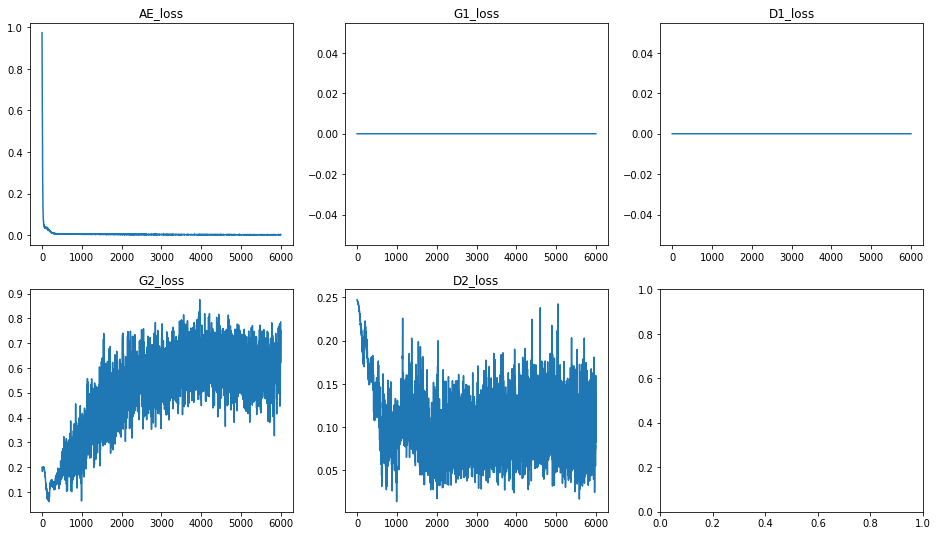

In [93]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(16,9))

ax[0, 0].plot(range(n_epochs-1), history["AE_loss"], label="AE_loss")
ax[0, 0].set_title("AE_loss")

ax[0, 1].plot(range(n_epochs-1), history["G1_loss"], label="G1_loss")
ax[0, 1].set_title("G1_loss")

ax[0, 2].plot(range(n_epochs-1), history["D1_loss"], label="D1_loss")
ax[0, 2].set_title("D1_loss")

ax[1, 0].plot(range(n_epochs-1), history["G2_loss"], label="G2_loss")
ax[1, 0].set_title("G2_loss")

ax[1, 1].plot(range(n_epochs-1), history["D2_loss"], label="D2_loss")
ax[1, 1].set_title("D2_loss")

plt.show()

In [130]:
reconmodel = keras.models.load_model(r'../GAN_log/New folder/autoencoder_epoch_5087.h5')

In [128]:
image = train_set[-9].reshape((1,48,96,96,1))
model.autoencoder.load_weights(r'../GAN_log/New folder/autoencoder_epoch_5087.h5')
gen_image=np.squeeze(model.autoencoder.predict(image))
image = np.squeeze(image)

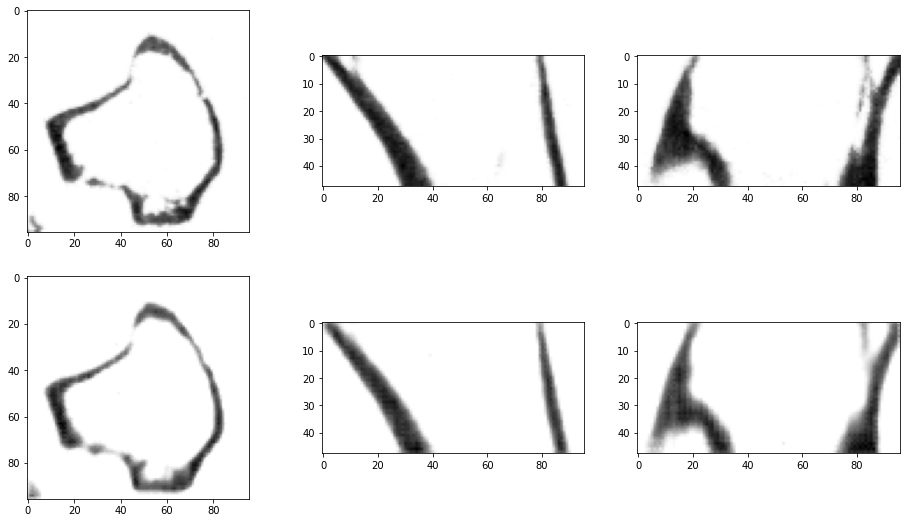

In [129]:
fig2, ax = plt.subplots(2,3, figsize=(16,9))
ax[0,0].imshow(image[35,:,:],cmap="Greys")
ax[1,0].imshow(gen_image[35,:,:],cmap="Greys")
ax[0,1].imshow(image[::-1,50,:],cmap="Greys")
ax[1,1].imshow(gen_image[::-1,50,:],cmap="Greys")
ax[0,2].imshow(image[::-1,:,60],cmap="Greys")
ax[1,2].imshow(gen_image[::-1,:,60],cmap="Greys")

In [104]:
#model = AAE(encoded_dim=256)
model.encoder.summary()

Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_272 (Conv3D)          (None, 48, 96, 96, 16)    448       
_________________________________________________________________
conv3d_273 (Conv3D)          (None, 24, 48, 48, 16)    6928      
_________________________________________________________________
batch_normalization_188 (Bat (None, 24, 48, 48, 16)    64        
_________________________________________________________________
conv3d_274 (Conv3D)          (None, 24, 48, 48, 32)    13856     
_________________________________________________________________
batch_normalization_189 (Bat (None, 24, 48, 48, 32)    128       
_________________________________________________________________
conv3d_275 (Conv3D)          (None, 12, 24, 24, 32)    27680     
_________________________________________________________________
batch_normalization_190 (Bat (None, 12, 24, 24, 32)  

In [105]:
model.decoder.summary()

Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_transpose_184 (Conv3D (None, 6, 12, 12, 128)    3584      
_________________________________________________________________
batch_normalization_196 (Bat (None, 6, 12, 12, 128)    512       
_________________________________________________________________
conv3d_transpose_185 (Conv3D (None, 6, 12, 12, 64)     221248    
_________________________________________________________________
batch_normalization_197 (Bat (None, 6, 12, 12, 64)     256       
_________________________________________________________________
conv3d_transpose_186 (Conv3D (None, 12, 24, 24, 64)    110656    
_________________________________________________________________
batch_normalization_198 (Bat (None, 12, 24, 24, 64)    256       
_________________________________________________________________
conv3d_transpose_187 (Conv3D (None, 12, 24, 24, 32)  

In [44]:
model.discriminator2.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_103 (Conv3D)          (None, 48, 96, 96, 16)    448       
_________________________________________________________________
conv3d_104 (Conv3D)          (None, 48, 96, 96, 16)    6928      
_________________________________________________________________
max_pooling3d_43 (MaxPooling (None, 24, 48, 48, 16)    0         
_________________________________________________________________
conv3d_105 (Conv3D)          (None, 24, 48, 48, 32)    13856     
_________________________________________________________________
conv3d_106 (Conv3D)          (None, 24, 48, 48, 32)    27680     
_________________________________________________________________
max_pooling3d_44 (MaxPooling (None, 12, 24, 24, 32)    0         
_________________________________________________________________
conv3d_107 (Conv3D)          (None, 12, 24, 24, 64)  

In [52]:
for layer in model.generator.layers:
    print(layer.trainable)

True
True
True


In [57]:
model.generator2.summary()

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
sequential_50 (Sequential)   (None, 48, 96, 96, 1)     2219409   
_________________________________________________________________
sequential_52 (Sequential)   (None, 1)                 69729     
Total params: 2,219,409
Trainable params: 2,219,409
Non-trainable params: 0
_________________________________________________________________


In [8]:
def resTP_block(input, filters = 64, kernel_size= 3, strides = (1,1,1), padding = "SAME", activate=keras.activations.relu, **kwargs):
    identity = input
    
    x = Conv3DTranspose(filters = filters, kernel_size=kernel_size, strides=strides, padding = padding, **kwargs)(input)
    x = BatchNormalization()(x)
    x = activate(x)

    x = Conv3DTranspose(filters = filters, kernel_size=kernel_size, strides=(1,1,1), padding = padding, **kwargs)(x)
    x = BatchNormalization()(x)    

    if np.prod(strides) > 1:
        identity = Conv3DTranspose(filters=filters, kernel_size=1, strides=strides, padding = padding, **kwargs)(identity)
        identity = BatchNormalization()(identity)  
    else:
        pass
    
    x = x + identity
    x = activate(x)

    return x

In [9]:
from tensorflow.keras.layers import BatchNormalization
input = tf.zeros(shape=(3,3,6,6,128))
output = resTP_block(input, filters=64, kernel_size=3, strides=(2,2,2), padding="SAME")

In [11]:
output.shape

TensorShape([3, 6, 12, 12, 64])